# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

import these libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm

from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



## Data Preparation



<div class='exercise'> <b> Question 1 </b> </div> 
  In HW3 Questions 1-3, you preprocessed the data in preparation for your regression analysis. We ask you to repeat those steps (particularly those in Question 3) so that we can compare the analysis models in this HW with those you developed in HW3.  In this HW we'll be using models from sklearn exclusively (as opposed to statsmodels)
  
**1.1** [From HW3] Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively.  Remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis.  Also remove the `casual` and `registered` columns for both training and test datasets as they make  `count` trivial.   

**1.2** Since we'll be exploring Regularization and Polynomial Features, it will make sense to standardize our data.  Standardize the numerical features. Store the dataframes for the processed training and test predictors into the variables `X_train` and `X_test`.  Store the appropriately shaped numpy arrays for the corresponding train and test `count` columns into `y_train` and `y_test`.

**1.3** Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train`.  Store the fitted model in the variable `BikeOLSModel`.

**1.4** What are the training and test set $R^2$ scores?  Store the training and test $R^2$ scores of the `BikeOLSModel` in a dictionary `BikeOLS_r2scores` using the string 'training' and 'test' as keys.  

**1.5**   We're going to use bootstrapped confidence intervals (use 500 bootstrap iterations) to determine which of the estimated coefficients for the `BikeOLSModel` are statistically significant at a significance level of 5% .  We'll do so by creating 3 different functions:

1. `make_bootstrap_sample(dataset_X, dataset_y)` returns a bootstrap sample of `dataset_X` and `dataset_y`
2. `calculate_coefficients(dataset_X, dataset_y, model)` returns in the form of a dictionary regression coefficients calculated by your model on `dataset_X` and `dataset_y`.  The keys for regression coefficients dictionary should be the names of the features.  The values should be the coefficient values of that feature calculated on your model.  An example would be {'hum': 12.3, 'windspeed': -1.2, 'Sunday': 0.6 ... }
3. `get_significant_predictors(regression_coefficients, significance_level)` takes as input a list of regression coefficient dictionaries (each one the output of `calculate_coefficients` and  returns a python list of the feature names of the significant predictors e.g. ['Monday', 'hum', 'holiday', ... ]

In the above functions `dataset_X` should always be a pandas dataframe with your features, `dataset_y` a numpy column vector with the values of the response variable and collectively they form the dataset upon which the operations take place. `model` is the `sklearn` regression model that will be used to generate the regression coefficients. `regression_coefficients` is a list of dictionaries of numpy arrays with each numpy array containing the regression coefficients (not including the intercept) calculated from one bootstrap sample.  `significance_level` represents the significance level as a floating point number.  So a 5% significance level should be represented as 0.05.  


Store the feature names as a list of strings in the variable `BikeOLS_significant_bootstrap` and print them for your answer.


### Answers

#### 1.1 Read `data/BSS_train.csv` and `data/BSS_test.csv` into Pandas DataFrames

In [3]:
# your code here
BSS_train=pd.read_csv("data/BSS_train.csv").drop(['Unnamed: 0','dteday', 'casual', 'registered'], axis=1)
BSS_test=pd.read_csv("data/BSS_test.csv").drop(['Unnamed: 0', 'dteday', 'casual', 'registered'], axis=1)


#### 1.2 Standardizing our data

In [4]:
# your code here
#Standardize the numeric predictors of training and test data
scaler = StandardScaler().fit(BSS_train[['temp', 'atemp', 'hum']])
transformed_train_num=scaler.transform(BSS_train[['temp', 'atemp', 'hum']]) 
transformed_test_num=scaler.transform(BSS_test[['temp', 'atemp', 'hum']]) 


In [5]:
#Drop the old numeric predictors from training and testing data, and combine transformed ones into a dataframe
x_train=BSS_train.drop(['counts', 'temp', 'atemp', 'hum'], axis=1)
transformed_features = pd.DataFrame({'temp':transformed_train_num[:,0],'atemp':transformed_train_num[:,1], 'hum':transformed_train_num[:,2]})
x_test=BSS_test.drop(['counts', 'temp', 'atemp', 'hum'], axis=1)
transformed_test_features = pd.DataFrame({'temp':transformed_test_num[:,0],'atemp':transformed_test_num[:,1], 'hum':transformed_test_num[:,2]})

In [6]:
#Merge the transformed numeric features into y_train and y_test
x_train[['temp', 'atemp', 'hum']]=transformed_features[['temp', 'atemp', 'hum']]
x_test[['temp', 'atemp', 'hum']]=transformed_test_features[['temp', 'atemp', 'hum']]

In [7]:
#Generate the dataframe of response variable
y_train=BSS_train['counts']
y_test=BSS_test['counts']

In [8]:
x_train.head()

,hour,holiday,year,workingday,windspeed,spring,summer,fall,Feb,Mar,...,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,temp,atemp,hum
0,0,0,0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.332339,-1.090615,0.937108
1,1,0,0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.436131,-1.179015,0.885320
2,2,0,0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.436131,-1.179015,0.885320
3,3,0,0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.332339,-1.090615,0.626377
4,4,0,0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.332339,-1.090615,0.626377


#### 1.3 Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression.

In [9]:
# your code here
BikeOLSModel = LinearRegression(fit_intercept = False).fit(x_train,y_train)


#### 1.4 What are the training and test set $R^2$ scores? Store the $R^2$ scores of the `BikeOLSModel` on the training and test sets in a dictionary `BikeOLS_r2scores`. 

<HR>
Your answer here:

**The training and testing set R2 scores are 0.4046 and 0.4037, respectively.**
<HR>

In [10]:
# your code here
R2_train=BikeOLSModel.score(x_train, y_train)
R2_test=BikeOLSModel.score(x_test, y_test)
BikeOLS_r2scores={}
BikeOLS_r2scores['Train_R2']=R2_train
BikeOLS_r2scores['Test_R2']=R2_test

In [11]:
BikeOLS_r2scores

{'Train_R2': 0.40455106458982126, 'Test_R2': 0.4036992405559716}

#### 1.5 We're going to use bootstrapped confidence intervals to determine which of the estimated coefficients ...

In [12]:
# your code here

# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    # your code here
    inds_to_sample = np.random.choice(y_train.shape[0], size=y_train.shape[0], replace=True)
    bootstrap_dataset_X = pd.DataFrame(columns=list(x_train.columns.values))
    for ele in x_train:
        bootstrap_dataset_X[ele] = x_train[ele][inds_to_sample]
    bootstrap_dataset_y = y_train[inds_to_sample]
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    coefficients_dictionary = dict()
    simp_reg =model().fit(dataset_X, dataset_y)
    for i, col in enumerate(dataset_X):
        coefficients_dictionary[col]=  simp_reg.coef_[i]
    # your code here
    
    # return coefficients  in the variable  coefficients_dictioanry as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    
    significant_coefficients = []
    
    # your code here
    for key in list(regression_coefficients[0].keys()):
        s_level=np.percentile([dic[key] for dic in regression_coefficients], [2.5, 97.5])
        if s_level[0]*s_level[1]>0:
            significant_coefficients.append(key)
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in th list should be the output of calculate_coefficients

    # return the significant coefficients as a list of strings
    return significant_coefficients

In [13]:
#Test the functions for bootstrap
adds=[]
for _ in range(0, 500):
    bootstrap0=make_bootstrap_sample(x_train, y_train, size = None)
    coefficients=calculate_coefficients(bootstrap0[0], bootstrap0[1], LinearRegression)
    adds.append(coefficients)
BikeOLS_significant_bootstrap=get_significant_predictors(adds, [2.5, 97.5])

In [14]:
print('The significant predictors from bootstrap are: {0}'.format(BikeOLS_significant_bootstrap))

The significant predictors from bootstrap are: ['hour', 'year', 'spring', 'summer', 'fall', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Oct', 'Nov', 'Sat', 'Cloudy', 'Snow', 'temp', 'hum']


## Penalization Methods

In HW 3 Question 5 we explored using subset selection to find a significant subset of features.  We then fit a regression model just on that subset of features instead of on the full dataset (including all features).   As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

<div class='exercise'> <b> Question 2 </b> </div> 
  We're going to use Ridge and Lasso regression regularization techniques to fit linear models to the training set.  We'll use cross-validation and shrinkage parameters $\lambda$ from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ to pick the best model for each regularization technique.

**2.1** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model on the training data.  Fit a Ridge Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeRRModel`.  Store the selected shrinkage parameter in the variable `BikeRR_shrinkage_parameter`.

**2.2** Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model on the training data.  Fit a Lasso Regression model on the training set with the selected shrinkage parameter and store your fitted model in the variable `BikeLRModel`.  Store the selected shrinkage parameter in the variable `BikeLR_shrinkage_parameter`.

**2.3** Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients for each of the regression models indexed by the string feature name.

**2.4** For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 (i.e. the absolute value of the coefficient is less than 0.1).  How closely do they match the redundant predictors found (if any) in HW 3, Question 5?

**2.5** To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).  Plot a bar graph of the magnitude (absolute value) of the estimated coefficients from Multiple Linear Regression in order from greatest to least.  Using a different color (and alpha values) overlay bar graphs of the magnitude of the estimated coefficients (in the same order as the Multiple Linear Regression coefficients) from Ridge and Lasso Regression.

**2.6** Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

**2.7** Discuss the Results:

1. How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Question 1? 
2. Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
3. Is the significance related to the shrinkage in some way?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.

### Answers

In [15]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

#### 2.1 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Ridge Regression model.

In [16]:
# your code here
ridgeCV_object = RidgeCV(alphas=(.001, .005, 1, 5, 10, 50, 100, 500, 1000), cv=5)
ridgeCV_object.fit(x_train, y_train)
BikeRRModel= Ridge(alpha = ridgeCV_object.alpha_).fit(x_train, y_train)
BikeRR_shrinkage_parameter=ridgeCV_object.alpha_

#### 2.2 Use 5-fold cross-validation to pick the best shrinkage parameter from the set $\{.001,.005,1,5,10,50,100,500,1000\}$ for your Lasso Regression model.

In [17]:
# your code here
lassoCV_object = LassoCV(alphas=(.001, .005, 1, 5, 10, 50, 100, 500, 1000), cv=5)
lassoCV_object.fit(x_train, y_train)
BikeLRModel=Lasso(alpha = lassoCV_object.alpha_).fit(x_train, y_train)
BikeLR_shrinkage_parameter=lassoCV_object.alpha_

#### 2.3 Create three dictionaries `BikeOLSparams`, `BikeLRparams`, and `BikeRRparams`.  Store in each the corresponding regression coefficients.

In [18]:
# your code here
BikeOLSparams= dict(zip(list(x_train.columns.values), list(BikeOLSModel.coef_)))
BikeRRparams = dict(zip(list(x_train.columns.values), list(BikeRRModel.coef_)))
BikeLRparams = dict(zip(list(x_train.columns.values), list(BikeLRModel.coef_)))

#### 2.4 For the Lasso and Ridge Regression models list the features that are assigned a coefficient value close to 0 ...

In [19]:
# your code here
def find_features(dic):
    cloo=[]
    for key in dic:
        if np.abs(dic[key])<0.1:
            cloo.append(key)
    return(cloo)

In [20]:
find_features(BikeOLSparams)

['Mon', 'Thu']

In [21]:
find_features(BikeRRparams)

[]

In [22]:
find_features(BikeLRparams)

['Mon']

<HR>
Your answer here:

**In HW3 Q5, more than 15 redudant predictors were removed, and here only Mon was located by Lasso regression model.**
<HR>

#### 2.5 To get a visual sense of how the features different regression models (Multiple Linear Regression, Ridge Regression, Lasso Regression) estimate coefficients, order the features by magnitude of the estimated coefficients in the Multiple Linear Regression Model (no shrinkage).

In [23]:
#Convert dictionary BikeOLSparams into dataframe, and add absolute value of coeficient column
OLS_df=pd.DataFrame.from_dict(BikeOLSparams, orient='index')
OLS_df_reindex=OLS_df.reset_index().rename(columns={'index':'predictors', 0: 'coef'})
OLS_df_reindex['abs_coef']=np.abs(OLS_df_reindex['coef'])

In [24]:
#Convert dictionary BikeRRarams into dataframe, and add absolute value of coeficient column
RR_df=pd.DataFrame.from_dict(BikeRRparams, orient='index')
RR_df_reindex=RR_df.reset_index().rename(columns={'index':'predictors', 0: 'coef'})
RR_df_reindex['abs_coef']=np.abs(RR_df_reindex['coef'])

In [25]:
#Convert dictionary BikeLRparams into dataframe, and add absolute value of coeficient column
LR_df=pd.DataFrame.from_dict(BikeLRparams, orient='index')
LR_df_reindex=LR_df.reset_index().rename(columns={'index':'predictors', 0: 'coef'})
LR_df_reindex['abs_coef']=np.abs(LR_df_reindex['coef'])

In [26]:
#Combine the RR_abs_coef and LR_abs_coef into OLS_df_reindex dataframe
OLS_df_reindex['RR_coef']=RR_df_reindex['abs_coef']
OLS_df_reindex['LR_coef']=LR_df_reindex['abs_coef']

In [27]:
#Sort the dataframe by absolute value of the coeffiencts of OLS model
frame_to_plot = OLS_df_reindex.sort_values(by=['abs_coef'], ascending=True)

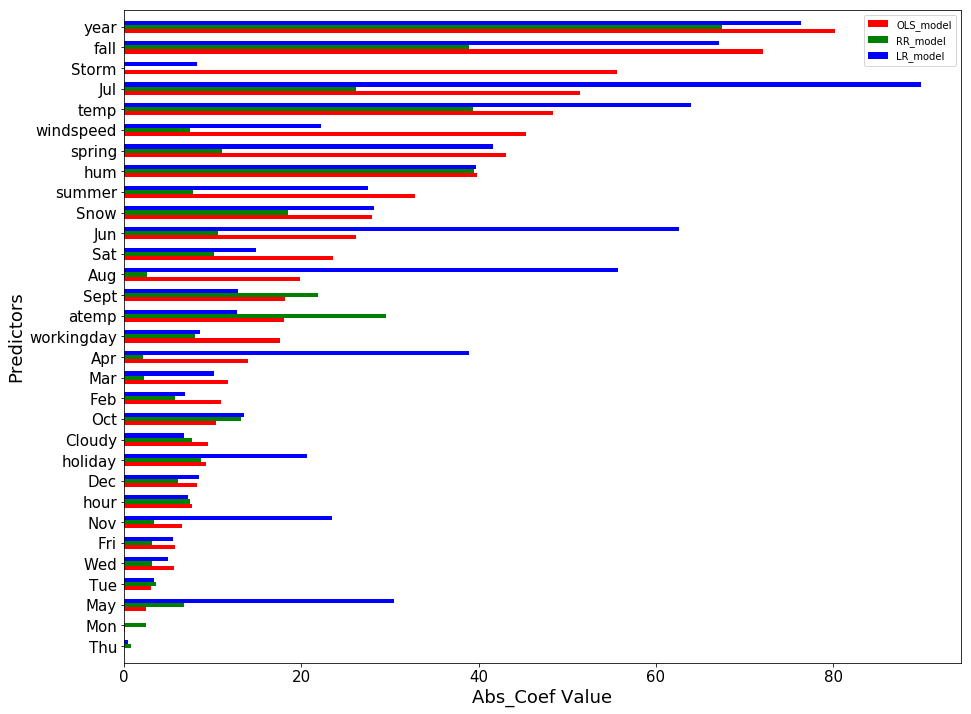

In [28]:
width = 0.2
position = np.arange(len(frame_to_plot))


fig, ax = plt.subplots(figsize=(15, 12))
ax.barh(position, frame_to_plot.abs_coef, width, color='r', label='OLS_model')
ax.barh(position + width, frame_to_plot.RR_coef, width, color='g', label='RR_model')
ax.barh(position + 2*width, frame_to_plot.LR_coef, width, color='b', label='LR_model')
ax.set(yticks=position + width, yticklabels=frame_to_plot.predictors, ylim=[2*width - 1, len(frame_to_plot)])
ax.tick_params(labelsize=15)
ax.set_xlabel('Abs_Coef Value', fontsize=18)
ax.set_ylabel('Predictors', fontsize=18)
ax.legend()

plt.show()

#### 2.6 Let's examine a pair of features we believe to be related.  Is there a difference in the way Ridge and Lasso regression assign coefficients ...v

<HR>
Your answer here:
    
**In Lasso regression model, temp has bigger coefficients and atemp has smaller coefficients; In Ridge model, the coefficients of temp and atemp are getting closer each other. The reason could be the Lasso model penalizes the predictor with colinearity harsher than Ridge model.**
<HR>

#### 2.7.1 How do the estimated coefficients compare to or differ from ...

<HR>
Your answer here：

**Compare to the plain linear regression, the weights of some predictors have changed a lot. In Lasso regression model, the coefficients including May, Nov, Apr, Holiday, Jun, Jul, Aug and temp, became more predominant, and storm became less significant. In Ridge regression model, hum, temp, Sept, fall, atemp, Jul, Snow and Oct outstood from the coefficients, and storm was not important any more.**
<HR>

#### 2.7.2 Is there a difference between coefficients estimated by the two shrinkage methods ...

<HR>
Your answer here:
    
**Yes. In Ridge model, most of the coefficients are smaller than the ones from Lasso model. The reason is because the Lasso model is sparser, while Ridge model is relatively more consertive. **
<HR>

#### 2.7.3 Is the significance related to the shrinkage in some way?

<HR>
Your answer here:
    
**In Lasso model, the significance shrunk quite fast, and could bring to zero at the end. In Ridge model, the shrinkage of the significance is slow.**
<HR>

<div class='exercise'> <b> Question 3: Polynomial Features, Interaction Terms, and Cross Validation </b> </div>


We would like to fit a model to include all main effects and polynomial terms for numerical predictors up to the $4^{th}$ order. More precisely use the following terms: 
 - predictors in `X_train` and `X_test`
 - $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ for each numerical predictor $X_j$

**3.1** Create an expanded training set including all the desired terms mentioned above. Store that training set (as a pandas dataframe) in the variable `X_train_poly`.  Create the corresponding test set and store it as a pandas dataframe in `X_test_poly`.

**3.2** Discuss the following:

1. What are the dimensions of this 'design matrix' of all the predictor variables in 3.1?  
2. What issues may we run into attempting to fit a regression model using all of these predictors?

**3.3** Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model to the training set data in `X_train_poly`.  Store the fitted model in the variable `BikeOLSPolyModel`.

**3.4** Discuss the following:
1. What are the training and test $R^2$ scores? 
2. How does the model performance compare with the OLS model on the original set of features in Question 1?

**3.5** The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample sets of $R^2$ for our model. Use 5-fold cross-validation to generate $R^2$ scores for the multiple linear regression model with polynomial terms.  What are the mean and standard deviation of the $R^2$ scores for your model.

**3.6** Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

**3.7** We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives:

1. Multiple linear regression model generated based upon the feature set in Question 1 (let's call these the base features.
2. base features plus polynomial features to order 2
3. base features plus polynomial features to order 4

Use 5-fold cross validation on the training set to select the best model.  Make sure to evaluate all the models as much as possible on the same folds.  For each model generate a mean and standard deviation for the $R^2$ score.

**3.8** Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best?

**3.9** Evaluate each of the model alternatives on the test set.  How do the results compare with the results from cross-validation?

### Answers

#### 3.1 Create an expanded training set including all the desired terms mentioned above. Store that training set (as a numpy array) in the variable `X_train_poly`....

In [29]:
# your code here
X_train3=x_train.copy()
y_train3=y_train.copy()
X_test3=x_test.copy()
y_test3=y_test.copy()

In [30]:
#Generate order 4 polynomial terms
poly = PolynomialFeatures(4, include_bias=False)
temp_poly=poly.fit_transform(X_train3.temp.values.reshape(-1,1))
atemp_poly=poly.fit_transform(X_train3.atemp.values.reshape(-1,1))
hum_poly=poly.fit_transform(X_train3.hum.values.reshape(-1,1))

In [31]:
#Combine the new terms into a dataframe
dataset_train = pd.DataFrame({'temp2':temp_poly[:,1],'temp3':temp_poly[:,2], 'temp4':temp_poly[:,3], 'atemp2': atemp_poly[:,1], 'atemp3':atemp_poly[:,2], 'atemp4':atemp_poly[:,3], 'hum2':hum_poly[:,1], 'hum3':hum_poly[:,2], 'hum4':hum_poly[:,3]})

In [32]:
dataset_train.head()

,temp2,temp3,temp4,atemp2,atemp3,atemp4,hum2,hum3,hum4
0,1.775128,-2.365072,3.151078,1.189440,-1.297221,1.414769,0.878172,0.822942,0.771186
1,2.062474,-2.961983,4.253797,1.390077,-1.638921,1.932313,0.783791,0.693905,0.614328
2,2.062474,-2.961983,4.253797,1.390077,-1.638921,1.932313,0.783791,0.693905,0.614328
3,1.775128,-2.365072,3.151078,1.189440,-1.297221,1.414769,0.392348,0.245757,0.153937
4,1.775128,-2.365072,3.151078,1.189440,-1.297221,1.414769,0.392348,0.245757,0.153937


In [33]:
#Standardize the new polynomial terms
scaler = StandardScaler().fit(dataset_train[dataset_train.columns.values])
dataset_train_std=scaler.transform(dataset_train[dataset_train.columns.values]) 


In [34]:
X_poly_train=X_train3

In [35]:
#Combine the new terms into the original dataframe
for i, col in enumerate(dataset_train):
    X_poly_train[col]=dataset_train_std[:, i]

In [36]:
#Generate order 4 polynomial terms for test data
temp_tpoly=poly.fit_transform(X_test3.temp.values.reshape(-1,1))
atemp_tpoly=poly.fit_transform(X_test3.atemp.values.reshape(-1,1))
hum_tpoly=poly.fit_transform(X_test3.hum.values.reshape(-1,1))

In [37]:
#Combine the new terms into a dataframe
dataset_test=pd.DataFrame({'temp2':temp_tpoly[:,1],'temp3':temp_tpoly[:,2], 'temp4':temp_tpoly[:,3], 'atemp2': atemp_tpoly[:,1], 'atemp3':atemp_tpoly[:,2], 'atemp4':atemp_tpoly[:,3], 'hum2':hum_tpoly[:,1], 'hum3':hum_tpoly[:,2], 'hum4':hum_tpoly[:,3]})

In [38]:
#Standardize the new polynomial terms
dataset_test_std=scaler.transform(dataset_test[dataset_train.columns.values])

In [39]:
X_poly_test=X_test3

In [40]:
#Merge the new terms into the original dataframe
for i, col in enumerate(dataset_train):
    X_poly_test[col]=dataset_test_std[:, i]

In [41]:
X_poly_test.head()

,hour,holiday,year,workingday,windspeed,spring,summer,fall,Feb,Mar,...,hum,temp2,temp3,temp4,atemp2,atemp3,atemp4,hum2,hum3,hum4
0,6,0,0,0,0.0000,0,0,0,0,0,...,0.885320,1.034363,-1.229342,0.550735,0.363342,-0.607571,-0.048217,-0.198713,0.301867,-0.280943
1,9,0,0,0,0.0000,0,0,0,0,0,...,0.678165,-0.154598,-0.320929,-0.337517,-0.423905,-0.124741,-0.406221,-0.496386,0.159758,-0.353046
2,20,0,0,0,0.2537,0,0,0,0,0,...,1.247840,-0.728206,-0.053431,-0.498855,-0.792867,0.009892,-0.466374,0.512022,0.766539,0.043090
3,10,0,0,0,0.2239,0,0,0,0,0,...,0.937108,-0.483353,-0.149138,-0.451260,-0.423905,-0.124741,-0.406221,-0.111969,0.349869,-0.252866
4,12,0,0,0,0.2985,0,0,0,0,0,...,0.160279,-0.483353,-0.149138,-0.451260,-0.295061,-0.188187,-0.369033,-0.895467,0.045265,-0.390789


#### 3.2.1 What are the dimensions of this 'design matrix'...**

In [42]:
X_poly_train.shape

(13903, 40)

In [43]:
X_poly_test.shape

(3476, 40)

<HR>
Your answer here:

**The dimnsions of the design matrix of training and test dataset are (13903, 40) and (3476, 40), respectively. **
<HR>

#### 3.2.2 What issues may we run into attempting to fit a regression model using all of these predictors? ...**

<HR>
Your answer here:

**If all the predictors are used in the model, the model will be very likely overfitted.**
<HR>

#### 3.3 Let's try fitting a regression model on all the predictors anyway.  Use the `LinearRegression` library from `sklearn` to fit a multiple linear regression model ....

In [44]:
# your code here
BikeOLSPolyModel = LinearRegression().fit(X_poly_train, y_train3)

#### 3.4.1 What are the training and test $R^2$ scores?

In [45]:
y_train_predict=BikeOLSPolyModel.predict(X_poly_train)
y_test_predict=BikeOLSPolyModel.predict(X_poly_test)

In [46]:
# your code here
r2_score(y_train3, y_train_predict)

0.4204663013821942

In [47]:
r2_score(y_test3, y_test_predict)

0.4200149935899714

<HR>
Your answer here:

**The R2 of training data is 0.42047, and the R2 of test data is 0.42001.**
<HR>

#### 3.4.2 How does the model performance compare with the OLS model on the original set of features in Question 1?

<HR>
Your answer here:

**R2 scores for both training and test data here are higher than the ones from OLS model in Q1.** 

<HR>

#### 3.5 The training set $R^2$ score we generated for our model with polynomial and interaction terms doesn't have any error bars.  Let's use cross-validation to generate sample...

In [49]:
# your code here
rsquared=[]
for train, valid in KFold(5, shuffle=True).split(range(X_poly_train.shape[0])):
    X_train1=X_poly_train.loc[train]
    y_train1=y_train3[train]
    model1=LinearRegression().fit(X_train1, y_train1)
    y_train1_predict=model1.predict(X_train1)
    rsquared.append(r2_score(y_train1, y_train1_predict))
R2_mean=np.mean(rsquared)
R2_sd=np.std(rsquared)

In [50]:
R2_mean

0.42083861598618066

In [51]:
R2_sd

0.0015674095372200953

<HR>
Your answer here:

**The mean and standard deviation of the CV model are 0.42084 and 0.00157, respectively.**
<HR>

#### 3.6 Visualize the $R^2$ scores generated from the 5-fold cross validation as a box and whisker plot.

Text(0.5,0,'R2 of CV model')

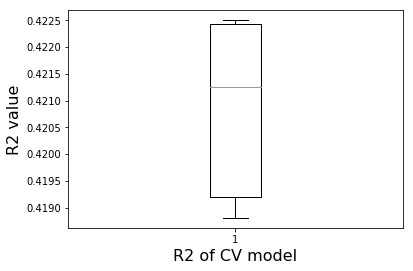

In [52]:
# your code here

plt.boxplot(rsquared);
plt.ylabel('R2 value', fontsize=16)
plt.xlabel('R2 of CV model', fontsize=16)

#### 3.7 We've used cross-validation to generate error bars around our $R^2$ scores, but another use of cross-validation is as a way of model selection.  Let's construct the following model alternatives ...

In [53]:
#Create dataframe with order 2 polynomial terms
X_order2=X_poly_train.drop(['temp3', 'temp4', 'atemp3', 'atemp4', 'hum3', 'hum4'],axis=1)

In [54]:
X_order2.head()

,hour,holiday,year,workingday,windspeed,spring,summer,fall,Feb,Mar,...,Sat,Cloudy,Snow,Storm,temp,atemp,hum,temp2,atemp2,hum2
0,0,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,-1.332339,-1.090615,0.937108,0.754620,0.176457,-0.111969
1,1,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,-1.436131,-1.179015,0.885320,1.034363,0.363342,-0.198713
2,2,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,-1.436131,-1.179015,0.885320,1.034363,0.363342,-0.198713
3,3,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,-1.332339,-1.090615,0.626377,0.754620,0.176457,-0.558479
4,4,0,0,0,0.0,0,0,0,0,0,...,1,0,0,0,-1.332339,-1.090615,0.626377,0.754620,0.176457,-0.558479


In [55]:
X_train_ori0=x_train.copy()

In [56]:
X_poly_train.head()

,hour,holiday,year,workingday,windspeed,spring,summer,fall,Feb,Mar,...,hum,temp2,temp3,temp4,atemp2,atemp3,atemp4,hum2,hum3,hum4
0,0,0,0,0,0.0,0,0,0,0,0,...,0.937108,0.754620,-0.981795,0.274524,0.176457,-0.474164,-0.161513,-0.111969,0.349869,-0.252866
1,1,0,0,0,0.0,0,0,0,0,0,...,0.885320,1.034363,-1.229342,0.550735,0.363342,-0.607571,-0.048217,-0.198713,0.301867,-0.280943
2,2,0,0,0,0.0,0,0,0,0,0,...,0.885320,1.034363,-1.229342,0.550735,0.363342,-0.607571,-0.048217,-0.198713,0.301867,-0.280943
3,3,0,0,0,0.0,0,0,0,0,0,...,0.626377,0.754620,-0.981795,0.274524,0.176457,-0.474164,-0.161513,-0.558479,0.135155,-0.363353
4,4,0,0,0,0.0,0,0,0,0,0,...,0.626377,0.754620,-0.981795,0.274524,0.176457,-0.474164,-0.161513,-0.558479,0.135155,-0.363353


In [57]:
# your code here
#Original Model
rsquared_ori=[]
rsquared_o2=[]
rsquared_o4=[]
#Loop through the validation and training sets
for train, valid in KFold(5, shuffle=True).split(range(X_poly_train.shape[0])):
    #Calculate R2 scores of original model
    X_train_ori=X_train_ori0.loc[train]
    y_train_all=y_train3[train]
    model_ori=LinearRegression().fit(X_train_ori, y_train_all)
    y_ori_predict=model_ori.predict(X_train_ori)
    rsquared_ori.append(r2_score(y_train_all, y_ori_predict))
    #Calculate R2 scores of order 2 model
    X_o2=X_order2.loc[train]    
    model_o2=LinearRegression().fit(X_o2, y_train_all)
    y_o2_predict=model_o2.predict(X_o2)
    rsquared_o2.append(r2_score(y_train_all, y_o2_predict))
    #Calculate R2 scores of order 4 model
    X_o4=X_poly_train.loc[train]    
    model_o4=LinearRegression().fit(X_o4, y_train_all)
    y_o4_predict=model_o4.predict(X_o4)
    rsquared_o4.append(r2_score(y_train_all, y_o4_predict))  

In [58]:
#Mean of R2 scores of original model
np.mean(rsquared_ori)

0.4067961778241429

In [59]:
#Standard deviation of R2 scores of original model
np.std(rsquared_ori)

0.0037661330210520794

In [60]:
#Mean of R2 scores of order 2 model
np.mean(rsquared_o2)

0.4109564090486554

In [61]:
#Standard deviation of R2 scores of order 2 model
np.std(rsquared_o2)

0.0036289479009718596

In [62]:
#Mean of R2 scores of order 4 model
np.mean(rsquared_o4)

0.42081517717435146

In [63]:
#Standard deviation of R2 scores of order 4 model
np.std(rsquared_o4)

0.003741948441464467

<HR>
Your answer here:
    
**Mean and standard deviation of the model with base features are 0.40680 and 0.00377, respectively;**
**Mean and standard deviation of the model with features to order2 are 0.41096 and 0.00363, respectively;**
**Mean and standard deviation of the model with features to order4 are 0.42082 and 0.00374, respectively;**

<HR>

#### 3.8 Visualize the $R^2$ scores generated for each model from 5-fold cross validation in box and whiskers plots.  Do the box and whisker plots influence your view of which model was best? ...

In [64]:
# your code here
R2_summary=pd.DataFrame(
    {'R2_ori': rsquared_ori,
     'R2_O2': rsquared_o2,
     'R2_O4': rsquared_o4
    })


In [65]:
R2_summary.T

,0,1,2,3,4
R2_ori,0.409162,0.400619,0.409898,0.404211,0.410091
R2_O2,0.413516,0.404829,0.413606,0.408741,0.414090
R2_O4,0.422551,0.414429,0.423348,0.418911,0.424837


Text(0,0.5,'R2 score')

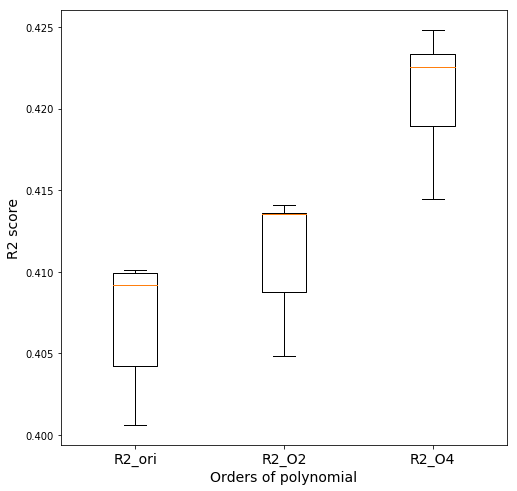

In [66]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(R2_summary.T);
ax.set_xticklabels(['R2_ori', 'R2_O2', 'R2_O4'], fontsize=14);
ax.set_xlabel('Orders of polynomial',fontsize=14)
ax.set_ylabel('R2 score', fontsize=14)

#### 3.9 Evaluate each of the model alternatives on the  test set.  How do the results compare with the results from cross-validation?

In [72]:
# your code here
#Generage test design matrices with features to order 2 and 4
X_test_o4= X_poly_test.copy()
X_test_ori=x_test.copy()
X_test_o2=X_test_o4.drop(['temp3', 'temp4', 'atemp3', 'atemp4', 'hum3', 'hum4'],axis=1)

In [68]:
y_test9=y_test.copy()

In [69]:
#Design matrices of training data with features to order2 and 4
X_train_ori9=x_train.copy()
X_train_o2=X_order2.copy()
X_train_o4=X_poly_train.copy()

In [70]:
y_train9=y_train3.copy()

In [74]:
#For multiple regression model
model_ori9=LinearRegression().fit(X_train_ori9, y_train9)
y_ori_predict9=model_ori9.predict(X_test_ori)
r2_score(y_test9, y_ori_predict9)

0.40638554757102274

In [75]:
#For model with order2
model_o2=LinearRegression().fit(X_train_o2, y_train9)
y_o2_predict9=model_o2.predict(X_test_o2)
r2_score(y_test9, y_o2_predict9)

0.41040722062021173

In [76]:
#For model with order4
model_o4=LinearRegression().fit(X_train_o4, y_train9)
y_o4_predict9=model_o4.predict(X_test_o4)
r2_score(y_test9, y_o4_predict9)

0.4200149935899714

<HR>
Your answer here:
    
**For the multiple regression model with base features, the R2 for test data is 0.40639; For the model with features to order 2, the R2 for test data is 0.41041; For the model with features to order 4, the R2 for test data is 0.42001.**
<HR>